In [1]:
import numpy as np
from functools import partial
import matplotlib.pyplot as plt 


# Comparison of Methods for 

In [2]:
print("test")

test


In [9]:
# Using U(q) = 1/2 q^2
# grad U (stochastic) = q + N(0,4) gaussian noise

def gradient_noise(q):
    # just -q since derivative is q
    grad = q + np.random.normal(0,2,1)# the third param is the output size,here is one number.
    return grad

def hmc_noise(q0,p0,h):
    # n is the size of the batch
    q = q0
    p = p0
    
    grad = gradient_noise(q)
    
    #added_noise = np.random.multivariate_normal(np.zeros(3), 2*h*B, 1)
    
    p = p - h*grad
    q = q + h*p
    
    return q, p

def hmc_friction(q0,p0,h):
    # n is the size of the batch
    q = q0
    p = p0
    
    grad = gradient_noise(q)
    cov = 1 # probably unnecessary
    
    p = p - h*grad - 4*h*p
    q = q + h*p
    
    return q, p


def run_simulation( q0,p0, Nsteps, h, step_function):
    
    q_traj = [np.copy(q0)] 
    p_traj = [np.copy(p0)]
    t_traj = [0]

    q = np.copy(q0) 
    p = np.copy(p0)
    t = 0 
    for n in range(Nsteps):
        q,p = step_function(q,p,h)
        t = t + h 

        q_traj += [q] 
        p_traj += [p]   
        t_traj += [t]

    q_traj = np.array(q_traj, dtype=object) 
    p_traj = np.array(p_traj, dtype=object) 
    t_traj = np.array(t_traj, dtype=object) 

    return q_traj, p_traj, t_traj

def run_simulation_resample( q0,p0, Nsteps, h, step_function,numResample):
    
    resample = False
    # numResample is the interval at which we should resample p
    q_traj = [np.copy(q0)] 
    p_traj = [np.copy(p0)]
    t_traj = [0]

    q = np.copy(q0) 
    p = np.copy(p0)
    t = 0 
    for n in range(Nsteps):
        if (n % numResample) == 0:
            resample = True
        else:
            resample = False
        if (resample):
            p = np.random.randn(1)
            
        q,p = step_function(q,p,h)
        t = t + h 

        q_traj += [q] 
        p_traj += [p]   
        t_traj += [t]

    q_traj = np.array(q_traj, dtype=object) 
    p_traj = np.array(p_traj, dtype=object) 
    t_traj = np.array(t_traj, dtype=object) 

    return q_traj, p_traj, t_traj

In [10]:
np.random.normal(0,2,1)

array([1.04297306])

In [11]:
Nsteps = 15000
h = 0.1

q0 = 0
p0 = 0

# Run one long trajectory of Nsteps, 
q_traj, p_traj, t_traj = run_simulation(q0, p0, Nsteps , h, hmc_noise)


# Run trajectory using resampling of p every 50 steps
q_traj2, p_traj2, t_traj2 = run_simulation_resample(q0, p0, Nsteps , h, hmc_noise, 50)


# run trajectory using friction (cov = 1)
q_traj3, p_traj3, t_traj3 = run_simulation(q0, p0, Nsteps , h, hmc_friction)


In [12]:
Nsteps = 15000
h = 0.1

q0 = 0
p0 = 2
def Verlet(q,p,h):
    
    # Compute the force
    f_old = -q
    
    pt_half = p + (h/2)*f_old
    qt = q + h*pt_half
    # Evaluate force at new q(t+h) point
    f = -qt
    pt = pt_half + (h/2)*f
    
    
    # Return values 
    return qt, pt
    

def run_simulation_ham( q0,p0, Nsteps, h, step_function):
    
    q_traj = [np.copy(q0)] 
    p_traj = [np.copy(p0)]
    t_traj = [0]

    q = np.copy(q0) 
    p = np.copy(p0)
    t = 0 
    for n in range(Nsteps):
        q,p = step_function(q,p,h)
        t = t + h 

        q_traj += [q] 
        p_traj += [p]   
        t_traj += [t]

    q_traj = np.array(q_traj) 
    p_traj = np.array(p_traj) 
    t_traj = np.array(t_traj) 

    return q_traj, p_traj, t_traj

q_traj_ham, p_traj_ham, t_traj_ham = run_simulation_ham(q0,p0,Nsteps, h, Verlet)

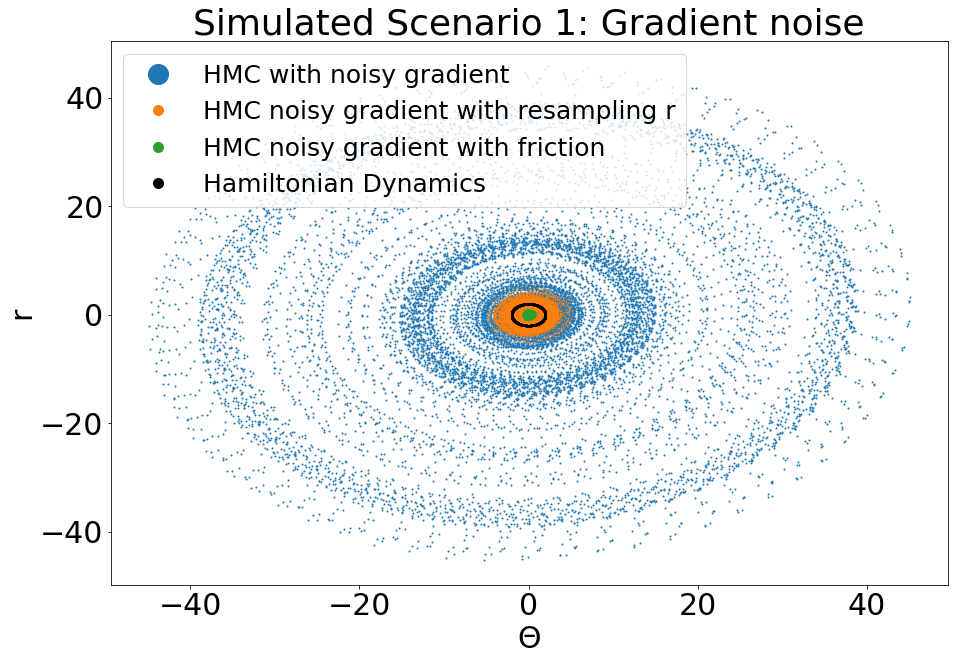

In [13]:
plt.figure(figsize=(15,10))
plt.rcParams.update({'font.size': 30})

plt.plot(q_traj,p_traj,'.', markersize=2, label='HMC with noisy gradient')
plt.plot(q_traj2,p_traj2,'.', markersize=1, label='HMC noisy gradient with resampling r')
plt.plot(q_traj3,p_traj3,'.',markersize=1, label='HMC noisy gradient with friction')
plt.plot(q_traj_ham, p_traj_ham,'k.', markersize=1, label='Hamiltonian Dynamics')
plt.xlabel('$ \Theta $')
plt.ylabel('r')
plt.legend(markerscale=20, prop={'size': 25})
plt.title('Simulated Scenario 1: Gradient noise')
plt.show()

In [3]:
# Experiment 2

# Using U(theta) = 1/2 theta^T Sigma^-1 theta
# grad U (stochastic) = sigma^-1 theta + N(0,I)


def gradient_cov(q,sigma):
    # just -q since derivative is q
    grad = np.dot(np.linalg.inv(sigma),q)
    return grad

def gradient_noise_cov(q,sigma):
    # just -q since derivative is q
    cov = np.array([[3,.1],[.1,4]])
    noise = cov @ np.random.randn(2)
    grad = np.dot(np.linalg.inv(sigma),q) + noise
    error = abs(noise)
    return grad, error

In [4]:

def hmc_friction_cov(q0,p0,h,sigma):
    # n is the size of the batch
    q = q0
    p = p0
    
    
    grad,error = gradient_noise_cov(q,sigma)
    
    p = p - h*grad - h*p
    q = q + h*p
    
    return q, p,error

In [5]:
def sgld_cov(q0,h, sigma):
    # n is the size of the batch
    q = q0
    
    grad,error = gradient_noise_cov(q, sigma)
    cov = 1 # probably unnecessary

    q = q - h/2*grad + np.random.normal(0,np.sqrt(h),1)
    
    return q

def run_simulation_sgld( q0, Nsteps, h, step_function, sigma):
    
    q_traj = [np.copy(q0)]  

    q = np.copy(q0)  

    for n in range(Nsteps):
        q = step_function(q, h, sigma) 

        q_traj += [q] 

    q_traj = np.array(q_traj)   

    return q_traj

In [6]:
def run_simulation_resample( q0,p0, Nsteps, h, step_function,numResample, sigma):
    
    resample = False
    # numResample is the interval at which we should resample p
    q_traj = [np.copy(q0)] 
    p_traj = [np.copy(p0)]
    t_traj = [0]

    q = np.copy(q0) 
    p = np.copy(p0)
    t = 0 
    cov_error = 0
    for n in range(Nsteps):
        if (n % numResample) == 0:
            resample = True
        else:
            resample = False
        if (resample):
            p = np.random.randn(len(p))
            
        q,p,error = step_function(q,p,h,sigma)
        t = t + h 

        q_traj += [q] 
        p_traj += [p]   
        t_traj += [t]
        cov_error += error

    q_traj = np.array(q_traj) 
    p_traj = np.array(p_traj) 
    t_traj = np.array(t_traj) 
    cov_error = cov_error/Nsteps

    return q_traj, p_traj, t_traj, cov_error


In [7]:
Nsteps = 100000
h = 0.1

sigma = np.array([[1,.9],[.9,1]])

q0 = np.array([1,0])
p0 = np.random.randn(2)





# Run trajectory using resampling of p every 50 steps
q_traj, p_traj, t_traj, cov_error = run_simulation_resample(q0, p0, Nsteps , h, hmc_friction_cov, 10, sigma)


q_traj_ld = run_simulation_sgld(q0,Nsteps,h,sgld_cov,sigma)


In [8]:
def U(x,y,sigma):
    sigma = np.linalg.inv(sigma)
    sigma1 = sigma[0,0]
    sigma2 = sigma[0,1]
    sigma3 = sigma[1,0]
    sigma4 = sigma[1,1]
    
    pot = sigma1*x**2 + sigma3*x*y + sigma2*x*y + sigma4*y**2
    return pot


U(1,2,sigma)


7.368421052631579

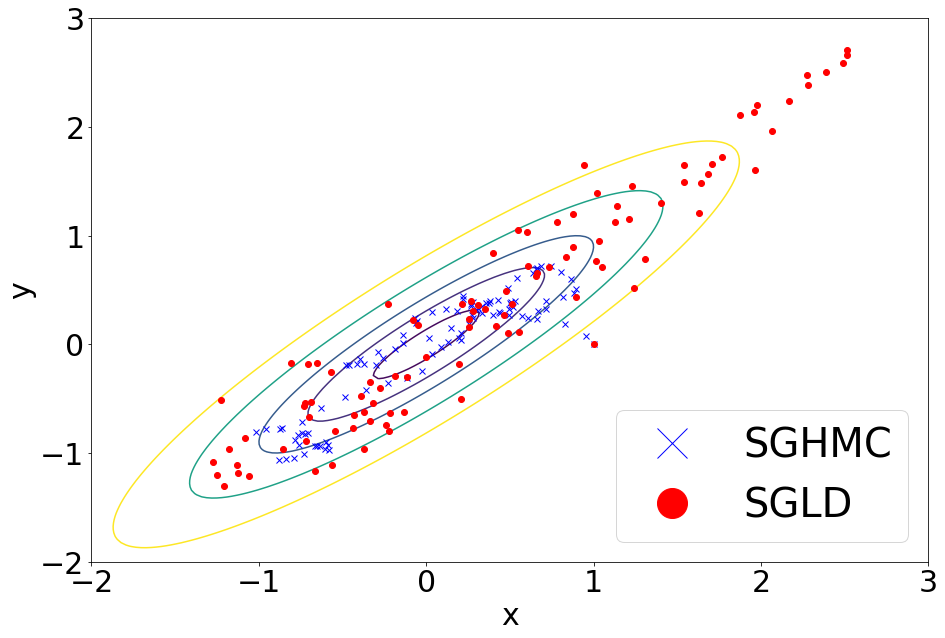

In [10]:
X,Y = np.meshgrid( np.linspace(-3,3,200) , np.linspace(-3,3,200) )
rho = U(X,Y,sigma)
plt.figure(figsize=(15,10))
plt.contour(X,Y,rho,levels=[0,.1,.5,1,2,3.5])

plt.rcParams.update({'font.size': 30})
plt.rcParams['axes.titlepad'] = 20 


plt.plot(q_traj[0:100,0], q_traj[0:100,1],'b.', markersize=6, label='SGHMC', marker="x")
plt.plot(q_traj_ld[0:100,0], q_traj_ld[0:100,1], 'rx', markersize=6, label='SGLD', marker="o")
#plt.plot(q_traj_metrop[:,0],q_traj_metrop[:,1],'b.', markersize = 1)
plt.xlabel('x')
plt.ylabel('y')
# plt.title('Simulated Scenario 2: Gradient noise for bivariate Gaussian')
axes = plt.gca()
axes.set_xlim([-2,3])
axes.set_ylim([-2,3])
plt.legend(markerscale=5, prop={'size': 40}, loc='lower right')
plt.savefig("figure3-2.png")
plt.show()


In [11]:
p = np.polyfit(q_traj[:,0], q_traj[:,1], 1)
print(p)

p2 = np.polyfit(q_traj_ld[:,0], q_traj_ld[:,1], 1)
print(p2)

print(np.mean(q_traj[:,0]))
print(np.var(q_traj[:,0]))

print(np.mean(q_traj[:,1]))
print(np.var(q_traj[:,1]))
print('sgld')
print(np.mean(q_traj_ld[:,0]))
print(np.var(q_traj_ld[:,0]))

print(np.mean(q_traj_ld[:,1]))
print(np.var(q_traj_ld[:,1]))

[0.91931226 0.00194434]
[ 0.99089767 -0.00387718]
0.01776296231552035
0.7101087458002044
0.01827404678574979
0.7337155309462953
sgld
-0.0037418924437054783
2.2578848619636114
-0.007585010132603196
2.295662538594525


In [12]:
type(np.asarray(rho))

numpy.ndarray

In [13]:
# autocorrelation function:

def acf(Phi,kmax):
    mean = np.mean(Phi)
    Phi_tmp = Phi - mean
    var = np.var(Phi)
    output = np.zeros(kmax)
    for i in range(kmax):
        output[i] = np.mean((Phi_tmp[i:] * Phi_tmp[:len(Phi)-i]))/var
        
    return output

def actime(acf_res):
    i = 0
    acf_sum = 0
    tau = 0
    while acf_res[i] >= 0.01:
        acf_sum = acf_sum + acf_res[i]
        i = i + 1
    tau = 1 + acf_sum
    return tau

acf_res1 = acf(q_traj[:,1],5000)
print(actime(acf_res1))



42.328702331023514


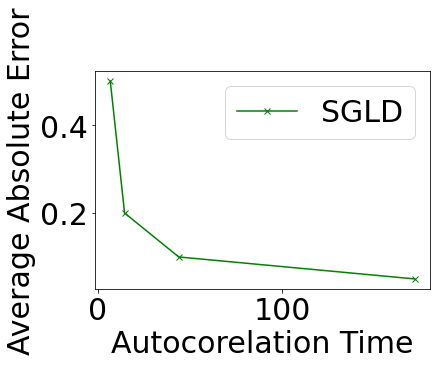

In [33]:
Nsteps = 10000
h = 0.1

sigma = np.array([[1,.9],[.9,1]])

q0 = np.array([1,0])
p0 = np.random.randn(2)


# Run trajectory using resampling of p every 50 steps
q_traj1, p_traj, t_traj, cov_error1 = run_simulation_resample(q0, p0, Nsteps , 0.05, hmc_friction_cov, 10, sigma)
q_traj2, p_traj, t_traj, cov_error2 = run_simulation_resample(q0, p0, Nsteps , 0.1, hmc_friction_cov, 10, sigma)
q_traj3, p_traj, t_traj, cov_error3 = run_simulation_resample(q0, p0, Nsteps , 0.2, hmc_friction_cov, 10, sigma)
q_traj4, p_traj, t_traj, cov_error4 = run_simulation_resample(q0, p0, Nsteps , 0.4, hmc_friction_cov, 10, sigma)
# q_traj5, p_traj, t_traj, cov_error5 = run_simulation_resample(q0, p0, Nsteps , 0.025, hmc_friction_cov, 10, sigma)

actimes = np.zeros(4)
acf_res1 = acf(q_traj1[:,1],10000)
actimes[0] = actime(acf_res1)
acf_res2 = acf(q_traj2[:,1],10000)
actimes[1] = actime(acf_res2)
acf_res3 = acf(q_traj3[:,1],10000)
actimes[2] = actime(acf_res3)
acf_res4 = acf(q_traj4[:,1],10000)
actimes[3] = actime(acf_res4)
# acf_res5 = acf(q_traj5[:,1],10000)
# actimes[4] = actime(acf_res5)


plt.plot(actimes,np.array([0.05,0.1,0.2,0.5]), color="blue", marker="x",label='SGLD')

plt.plot(actimes,np.array([0.05,0.1,0.2,0.5]), color="red", marker="o",label='SGHMC')

# plt.title('Autocorrelation times for different timesteps')
plt.xlabel('Autocorelation Time')
plt.ylabel('Average Absolute Error')
plt.legend()
plt.savefig("figure3-1.png")
plt.show()

In [28]:
np.array(range(5))

array([0, 1, 2, 3, 4])